# 🚀 Multi-Agent API Documentation Assistant

---

## 📋 Project Overview & Architecture

This project implements an intelligent **multi-agent system** that helps developers quickly understand and use **any API** by:

- 🔍 **Finding** the official documentation  
- 📄 **Extracting** relevant content  
- 🧠 **Understanding** the API via **Retrieval-Augmented Generation (RAG)**  
- 🧑‍💻 **Generating** working code examples  
- 💬 **Explaining** how to use the API clearly and accurately  

---

## 🏗️ Architecture Overview


User Query → Web Search Agent → Documentation Extractor → RAG System → Code Generator → Final Output

🤖 Agents

Web Search Agent: Finds official API documentation
Documentation Extractor: Parses and structures API docs
RAG Agent: Retrieves relevant information
Code Generator: Creates working examples with explanations


🛠️ Environment Setup & Dependencies

In [ ]:
# Install all required dependencies
!pip install -q langchain langchain-openai langchain-community chromadb beautifulsoup4 requests tiktoken faiss-cpu numpy pandas matplotlib seaborn tabulate lxml html5lib langchain-experimental

# Additional installations for MCP (Model Context Protocol)
!pip install -q mcp-client pymcp

In [ ]:
import os
import json
import requests
from typing import List, Dict, Any, Optional, Tuple
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# LangChain imports
from langchain.agents import Tool, AgentExecutor, create_react_agent
from langchain.prompts import PromptTemplate
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.memory import ConversationBufferMemory
from langchain_openai import ChatOpenAI
from langchain.tools import StructuredTool
from langchain.pydantic_v1 import BaseModel, Field

# Web scraping
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse

# MCP imports
try:
    from mcp import Client as MCPClient
    from mcp.types import Tool as MCPTool
    MCP_AVAILABLE = True
except ImportError:
    MCP_AVAILABLE = False
    print("⚠️ MCP not available. Installing mock version for compatibility.")

# Set up environment
os.environ["OPENAI_API_KEY"] = 'sk-'

print("✅ Environment setup complete!")

⚠️ MCP not available. Installing mock version for compatibility.
✅ Environment setup complete!


🔌 API Connections & Data Sources


In [ ]:
!pip install -q openai          # Colab / notebook install
from openai import OpenAI       # NEW
client = OpenAI()               # NEW


In [ ]:
# Initialize OpenAI models
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    temperature=0.7,
    max_tokens=2000
)


embeddings = OpenAIEmbeddings()

print("✅ OpenAI models initialized successfully!")

✅ OpenAI models initialized successfully!


💡 Core Implementation


1️⃣ Web Search Agent Implementation

### WebSearchTool: Retrieve Relevant API Documentation in Real Time

This class is responsible for conducting real-time web searches to locate official API documentation.  
I use OpenAI's `web_search_preview` tool to intelligently search for the most relevant API reference pages based on a given user query.

The main method, `search`, enhances the query with keywords like "official documentation" to prioritize high-quality results.  
It extracts URLs and attempts to select the one most likely to point to official docs, using common documentation-related keywords in the URL.  
The result includes the URL, a parsed title, a short description (up to 25k characters), and the full response text for further use downstream.


In [ ]:
class WebSearchTool:
    """Real-time web search powered by OpenAI's web_search_preview tool"""

    def __init__(self, client: OpenAI):
        self.client = client

    def search(self, query: str) -> Dict[str, Any]:
        """Search for API documentation using OpenAI's web search"""
        try:
            # Add "official documentation" to improve search results
            search_query = f"{query} official documentation API reference"

            response = self.client.responses.create(
                model="gpt-4.1",
                tools=[{"type": "web_search_preview"}],
                input=search_query
            )

            text = response.output_text

            # Extract URLs from the response
            import re
            urls = re.findall(r'https?://[^\s<>"\']+', text)

            # Get the first URL that looks like documentation
            doc_url = ""
            for url in urls:
                if any(keyword in url.lower() for keyword in ['docs', 'documentation', 'api', 'reference', 'guide']):
                    doc_url = url
                    break

            if not doc_url and urls:
                doc_url = urls[0]

            # Extract title from the response
            title_match = re.search(r'(?:documentation|api|guide)\s*(?:for|of)?\s*([^\.]+)', text, re.IGNORECASE)
            title = title_match.group(1).strip() if title_match else "API Documentation"

            return {
                "url": doc_url,
                "title": title,
                "description": text[:25000] + "...",
                "full_response": text  # Keep full response for context
            }

        except Exception as e:
            print(f"Web search error: {e}")
            return {
                "url": "",
                "title": "Search failed",
                "description": str(e),
                "full_response": ""
            }

2️⃣ Documentation Extractor Agent


### DocumentationExtractor: Parse and Structure API Documentation from Web Pages

This class is responsible for extracting structured content from raw HTML pages containing API documentation.  
I fetch the page using `requests` and parse it using `BeautifulSoup`, then identify key content regions such as `<main>`, `<article>`, or known documentation class selectors.

The `extract_from_url` method performs the following:

- Fetches and parses the HTML content from the given URL
- Strips out irrelevant tags like `<script>` and `<style>`
- Extracts section titles (`h1`, `h2`, `h3`) and gathers surrounding text content
- Collects a limited number of meaningful code examples (`<pre>` and `<code>` blocks)
- Returns a structured dictionary containing:
  - The page title
  - A truncated version of the full text content
  - A dictionary of sections and their summaries
  - A list of sample code snippets

If anything fails during extraction, the `_get_fallback_docs` method provides a safe default response.  
This class ensures I have clean, structured input for downstream vectorization and retrieval.


In [ ]:


class DocumentationExtractor:
    """Extract and parse API documentation from web pages"""

    def __init__(self):
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"
        }

    def extract_from_url(self, url: str) -> Dict[str, Any]:
        """Extract documentation content from URL"""
        try:
            if not url:
                return self._get_fallback_docs(url)

            print(f"   Fetching content from: {url}")
            response = requests.get(url, headers=self.headers, timeout=15)
            response.raise_for_status()

            soup = BeautifulSoup(response.content, "html.parser")

            # Remove script and style elements
            for script in soup(["script", "style"]):
                script.decompose()

            # Extract title
            title = soup.find("title")
            title_text = title.get_text(strip=True) if title else "API Documentation"

            # Look for main content areas
            main_content = None
            for selector in [
                "main",
                "article",
                '[role="main"]',
                ".documentation",
                ".docs-content",
                "#content",
            ]:
                main_content = soup.select_one(selector)
                if main_content:
                    break

            if not main_content:
                main_content = soup.find("body")

            # Extract sections
            sections: dict[str, str] = {}
            headers = (
                main_content.find_all(["h1", "h2", "h3"]) if main_content else []
            )

            for header in headers[:10]:  # Limit to first 10 sections
                section_title = header.get_text(strip=True)
                section_content = ""

                # Get content after this header until next header
                for sibling in header.find_next_siblings():
                    if sibling.name in ["h1", "h2", "h3"]:
                        break
                    section_content += sibling.get_text(strip=True) + " "

                if section_content.strip():
                    sections[section_title] = section_content[:500]

            # Extract code examples
            examples = []
            code_blocks = soup.find_all(["code", "pre"])

            for i, block in enumerate(code_blocks[:5]):  # Limit to first 5 examples
                code_text = block.get_text(strip=True)
                if len(code_text) > 50:  # Only meaningful code blocks
                    examples.append(
                        {
                            "code": code_text,
                            "description": f"Code example {i+1}",
                        }
                    )

            # Get full text content
            text_content = (
                main_content.get_text(separator=" ", strip=True)
                if main_content
                else ""
            )

            return {
                "url": url,
                "title": title_text,
                "content": text_content[:5000],  # Limit content
                "sections": sections,
                "examples": examples,
            }

        except Exception as e:
            print(f"   Extraction error: {e}")
            return self._get_fallback_docs(url)

    def _get_fallback_docs(self, url: str) -> Dict[str, Any]:
        """Fallback documentation structure"""
        return {
            "url": url,
            "title": "API Documentation",
            "content": "API documentation content",
            "sections": {},
            "examples": [],
        }


# Initialize documentation extractor
doc_extractor = DocumentationExtractor()
print("✅ Documentation Extractor ready!")

# Initialize web search tool with OpenAI client (ensure client is defined)
# web_search_tool = WebSearchTool(client)
print("✅ Web Search Tool ready!")


✅ Documentation Extractor ready!
✅ Web Search Tool ready!


3️⃣ RAG System Implementation


### RAGSystem: Core Retrieval-Augmented Generation Engine

This class implements the core logic for embedding, storing, and retrieving API documentation using Retrieval-Augmented Generation (RAG).  
I use this system to semantically understand and answer technical queries based on ingested documentation.

The `RAGSystem` class includes the following:

- `__init__`: Sets up the embedding model and initializes a text splitter to divide long documents into overlapping chunks.
- `ingest_documentation`: Converts raw documentation into `Document` objects, splits them into smaller chunks, and stores them in a Chroma vector database.
  - It ingests content from main text, section summaries, and code examples.
- `retrieve_relevant_info`: Given a user query, retrieves the most semantically relevant document chunks from the vector store.
- `get_retrieval_chain`: Returns a LangChain `RetrievalQA` chain that wraps the retriever and language model for contextual question answering.

This system forms the backbone of my assistant’s ability to retrieve and reason over real documentation content.


In [ ]:
class RAGSystem:
    """Retrieval Augmented Generation system for API docs"""

    def __init__(self, embeddings):
        self.embeddings = embeddings
        self.vector_store = None
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len
        )

    def ingest_documentation(self, doc_data: Dict[str, Any]) -> None:
        """Ingest documentation into vector store"""
        # Create documents from different sections
        documents = []

        # Main content
        if doc_data.get("content"):
            documents.append(Document(
                page_content=doc_data["content"],
                metadata={"type": "overview", "source": doc_data.get("url", "")}
            ))

        # Sections
        for section_name, section_content in doc_data.get("sections", {}).items():
            documents.append(Document(
                page_content=f"{section_name}: {section_content}",
                metadata={"type": "section", "section": section_name}
            ))

        # Examples
        for example in doc_data.get("examples", []):
            example_text = json.dumps(example, indent=2)
            documents.append(Document(
                page_content=f"Example: {example.get('description', '')}\n{example_text}",
                metadata={"type": "example", "endpoint": example.get("endpoint", "")}
            ))

        # Split documents
        split_docs = self.text_splitter.split_documents(documents)

        # Create vector store
        self.vector_store = Chroma.from_documents(
            documents=split_docs,
            embedding=self.embeddings,
            collection_name="api_docs"
        )

        print(f"✅ Ingested {len(split_docs)} document chunks into RAG system")

    def retrieve_relevant_info(self, query: str, k: int = 5) -> List[Document]:
        """Retrieve relevant information for the query"""
        if not self.vector_store:
            return []

        relevant_docs = self.vector_store.similarity_search(query, k=k)
        return relevant_docs

    def get_retrieval_chain(self, llm):
        """Get a retrieval QA chain"""
        if not self.vector_store:
            raise ValueError("No documents ingested yet")

        return RetrievalQA.from_chain_type(
            llm=llm,
            chain_type="stuff",
            retriever=self.vector_store.as_retriever(search_kwargs={"k": 5}),
            return_source_documents=True
        )

# Initialize RAG system
rag_system = RAGSystem(embeddings)
print("✅ RAG System initialized!")

✅ RAG System initialized!


4️⃣ MCP Integration Layer


### MCPIntegration: Shared Context & Tool Orchestration Layer

This class implements an internal **Model Context Protocol (MCP)** to enable coordinated communication between agents and tools.  
I use it to register tools, call them dynamically, and store intermediate results in a shared context for later use.

Key components of `MCPIntegration`:

- `register_tool`: Registers a callable tool with a name and description. Tracks usage count and last execution timestamp.
- `call_tool`: Invokes a registered tool with the given arguments, updates its metadata, and stores the result in a centralized context.
- `add_to_context` / `get_context`: Adds and retrieves values from the context store, which acts like a shared memory for tools and agents.
- `get_context_summary`: Returns a human-readable summary of the context store, including the type and timestamp of each stored variable.

I use this abstraction to cleanly manage inter-agent communication and preserve intermediate outputs across steps of the pipeline.


In [ ]:
class MCPIntegration:
    """Model Context Protocol integration for enhanced agent communication"""

    def __init__(self):
        self.context_store = {}
        self.tool_registry = {}

    def register_tool(self, name: str, description: str, func: callable):
        """Register a tool in the MCP registry"""
        self.tool_registry[name] = {
            "description": description,
            "function": func,
            "calls": 0,
            "last_called": None
        }
        print(f"📌 MCP: Registered tool '{name}'")

    def call_tool(self, name: str, **kwargs) -> Any:
        """Call a registered tool through MCP"""
        if name not in self.tool_registry:
            raise ValueError(f"Tool '{name}' not found in MCP registry")

        tool = self.tool_registry[name]
        tool["calls"] += 1
        tool["last_called"] = datetime.now()

        # Execute tool
        result = tool["function"](**kwargs)

        # Store in context
        self.add_to_context(f"{name}_result", result)

        return result

    def add_to_context(self, key: str, value: Any):
        """Add information to the shared context"""
        self.context_store[key] = {
            "value": value,
            "timestamp": datetime.now(),
            "type": type(value).__name__
        }

    def get_context(self, key: str) -> Any:
        """Retrieve information from shared context"""
        if key in self.context_store:
            return self.context_store[key]["value"]
        return None

    def get_context_summary(self) -> str:
        """Get a summary of the current context"""
        summary = "🔍 MCP Context Summary:\n"
        for key, data in self.context_store.items():
            summary += f"  • {key}: {data['type']} (stored at {data['timestamp'].strftime('%H:%M:%S')})\n"
        return summary

# Initialize MCP integration
mcp = MCPIntegration()
print("✅ MCP Integration layer ready!")

# Register our tools with MCP
mcp.register_tool("web_search", "Search for API documentation", web_search_tool.search)
mcp.register_tool("extract_docs", "Extract documentation from URL", doc_extractor.extract_from_url)
mcp.register_tool("retrieve_info", "Retrieve relevant information using RAG", rag_system.retrieve_relevant_info)

✅ MCP Integration layer ready!
📌 MCP: Registered tool 'web_search'
📌 MCP: Registered tool 'extract_docs'
📌 MCP: Registered tool 'retrieve_info'


5️⃣ Code Generator Agent


### CodeGeneratorAgent: Code Generation from Retrieved API Knowledge

This class is responsible for generating Python code examples based on retrieved API documentation chunks.  
I use it to synthesize clean, working code tailored to a user's query using an LLM, and return not only the code but also a full explanation, setup steps, and common pitfalls.

The `generate_code` method performs the following:

- Builds a rich prompt combining the user query and relevant documentation
- Instructs the model to return a structured JSON with four required keys:
  - `code`: Complete, runnable Python script
  - `explanation`: Step-by-step logic breakdown
  - `setup`: Any initial setup instructions (e.g., installing packages or obtaining API keys)
  - `pitfalls`: A list of mistakes or caveats to avoid
- Tries to parse the response as JSON; if that fails, uses a fallback parser to extract a usable code block
- Stores the result in the MCP context for use by other agents

Fallback methods ensure graceful degradation in case of formatting issues in the LLM output.  
This component ensures every user query results in actionable, explainable code that’s ready to run.


In [ ]:
class CodeGeneratorAgent:
    """Generate code examples based on API documentation"""

    def __init__(self, llm, mcp):
        self.llm = llm
        self.mcp = mcp

    def generate_code(self, query: str, api_info: List[Document]) -> Dict[str, Any]:
        """Generate code example with explanation"""
        # Compile API information
        context = "\n".join([doc.page_content for doc in api_info])

        prompt = f"""
        You are an expert developer. Based on the API documentation provided, generate code to accomplish this task:
        {query}

        API Documentation:
        {context}

        Requirements:
        1. Provide complete, working Python code
        2. Include all necessary imports
        3. Add helpful comments
        4. Handle errors appropriately
        5. Use best practices

        Return a JSON object with these exact keys:
        - "code": Complete Python code as a string
        - "explanation": Step-by-step explanation of how the code works
        - "setup": Any required setup steps (installing packages, getting API keys, etc.)
        - "pitfalls": List of common mistakes to avoid

        Make sure to return valid JSON that can be parsed.
        """




        try:
            response = self.llm.predict(prompt)

            # Parse response (with fallback)
            try:
                result = json.loads(response)
            except:
                # Fallback parsing
                result = self._parse_response_fallback(response, query)

            # Store in MCP context
            self.mcp.add_to_context("generated_code", result)

            return result

        except Exception as e:
            print(f"Code generation error: {e}")
            return self._get_fallback_code(query)

    def _parse_response_fallback(self, response: str, query: str) -> Dict[str, Any]:
        """Fallback parser for non-JSON responses"""
        return {
            "code": self._extract_code_block(response),
            "explanation": "Follow the code comments for step-by-step guidance.",
            "setup": "Install required packages and set up API credentials.",
            "pitfalls": ["Ensure API key is valid", "Check rate limits", "Handle errors gracefully"]
        }

    def _extract_code_block(self, text: str) -> str:
        """Extract code from text"""
        if "```python" in text:
            start = text.find("```python") + 9
            end = text.find("```", start)
            return text[start:end].strip()
        elif "```" in text:
            start = text.find("```") + 3
            end = text.find("```", start)
            return text[start:end].strip()
        else:
            # Return a generic template
            return """
import requests

# Set up API credentials
API_KEY = "your_api_key_here"
BASE_URL = "https://api.example.com/v1"

# Make API request
headers = {"Authorization": f"Bearer {API_KEY}"}
response = requests.get(f"{BASE_URL}/endpoint", headers=headers)

# Process response
if response.status_code == 200:
    data = response.json()
    print(data)
else:
    print(f"Error: {response.status_code}")
"""

    def _get_fallback_code(self, query: str) -> Dict[str, Any]:
        """Fallback code generation"""
        return {
            "code": self._extract_code_block(""),
            "explanation": f"Generic code template for: {query}",
            "setup": "Replace placeholder values with actual API details",
            "pitfalls": ["Verify API endpoint", "Use correct authentication method"]
        }

# Initialize code generator
code_generator = CodeGeneratorAgent(llm, mcp)
print("✅ Code Generator Agent ready!")

✅ Code Generator Agent ready!


🔧 Agent/Model Definitions

Multi-Agent Orchestrator

### MultiAgentOrchestrator: End-to-End Coordination of the API Assistant Pipeline

This class serves as the central orchestrator that coordinates the full multi-agent workflow to fulfill a user’s technical request.  
I use it to sequentially invoke each component—from web search to documentation extraction, semantic retrieval, code generation, and response assembly.

The `process_query` method follows these key stages:

1. **Web Search**: Enhances the user’s query if needed and uses the MCP layer to call the `web_search` tool.
2. **Documentation Extraction**: Extracts structured content from the discovered documentation page.
3. **RAG Ingestion**: Feeds the cleaned and structured content into the vector store for semantic indexing.
4. **Semantic Retrieval**: Retrieves the most relevant documentation chunks based on the user’s original query.
5. **Code Generation**: Uses those chunks to generate executable Python code with explanations, setup instructions, and pitfalls.

Additional functionality:

- `validate_and_retry`: Optional retry mechanism to validate intermediate results and re-attempt extraction or search if needed.
- `_log_step`: Captures a step-by-step execution log to track what happened at each stage of the pipeline.

The orchestrator compiles everything—retrieved docs, code, explanation, context, and logs—into a structured result that can be returned or rendered in a UI.


In [ ]:
class MultiAgentOrchestrator:
    """Orchestrate multiple agents to fulfill user requests"""

    def __init__(self, web_search, doc_extractor, rag_system, code_generator, mcp):
        self.web_search = web_search
        self.doc_extractor = doc_extractor
        self.rag_system = rag_system
        self.code_generator = code_generator
        self.mcp = mcp
        self.execution_log = []

    def process_query(self, query: str) -> Dict[str, Any]:
        """Process user query through the multi-agent pipeline"""
        print(f"\n🎯 Processing query: {query}")
        self._log_step("Query received", {"query": query})

        # Step 1: Web Search
        print("\n1️⃣ Searching for API documentation...")
        # Enhanced search with context
        enhanced_query = query
        if "how to use" in query.lower() and "api" in query.lower():
            # Query is already well-formed
            pass
        else:
            enhanced_query = f"how to use {query} API documentation"

        search_result = self.mcp.call_tool("web_search", query=enhanced_query)





        self._log_step("Web search completed", search_result)
        print(f"   Found: {search_result['title']}")
        print(f"   URL: {search_result['url']}")

        # Step 2: Extract Documentation
        print("\n2️⃣ Extracting documentation content...")
        doc_data = self.mcp.call_tool("extract_docs", url=search_result['url'])
        self._log_step("Documentation extracted", {"sections": len(doc_data.get('sections', {}))})
        print(f"   Extracted {len(doc_data.get('sections', {}))} sections")

        # Step 3: Ingest into RAG
        print("\n3️⃣ Ingesting documentation into RAG system...")
        self.rag_system.ingest_documentation(doc_data)
        self._log_step("RAG ingestion completed", {"status": "success"})

        # Step 4: Retrieve relevant information
        print("\n4️⃣ Retrieving relevant information...")
        relevant_docs = self.mcp.call_tool("retrieve_info", query=query, k=5)
        self._log_step("Information retrieved", {"docs_count": len(relevant_docs)})
        print(f"   Found {len(relevant_docs)} relevant documentation chunks")

        # Step 5: Generate code
        print("\n5️⃣ Generating code and explanation...")
        code_result = self.code_generator.generate_code(query, relevant_docs)
        self._log_step("Code generated", {"has_code": bool(code_result.get('code'))})

        # Compile final result
        final_result = {
            "query": query,
            "documentation_url": search_result['url'],
            "code": code_result.get('code', ''),
            "explanation": code_result.get('explanation', ''),
            "setup": code_result.get('setup', ''),
            "pitfalls": code_result.get('pitfalls', []),
            "relevant_docs": [doc.page_content[:200] + "..." for doc in relevant_docs[:3]],
            "mcp_context": self.mcp.get_context_summary(),
            "execution_log": self.execution_log
        }

        print("\n✅ Processing complete!")
        return final_result

    def _log_step(self, step: str, data: Any):
        """Log execution step"""
        self.execution_log.append({
            "timestamp": datetime.now().isoformat(),
            "step": step,
            "data": data
        })

    def validate_and_retry(self, step_name: str, result: Any, retry_func: callable, max_retries: int = 2) -> Any:
      """Validate results and retry if needed"""
      retries = 0
      while retries < max_retries:
          if step_name == "web_search" and not result.get('url'):
              print(f"   Retry {retries + 1}: No URL found, searching again...")
              result = retry_func()
          elif step_name == "extract_docs" and not result.get('content'):
              print(f"   Retry {retries + 1}: No content extracted, trying again...")
              result = retry_func()
          else:
              break
          retries += 1
      return result

# Initialize orchestrator
orchestrator = MultiAgentOrchestrator(
    web_search=web_search_tool,
    doc_extractor=doc_extractor,
    rag_system=rag_system,
    code_generator=code_generator,
    mcp=mcp
)
print("✅ Multi-Agent Orchestrator ready!")

✅ Multi-Agent Orchestrator ready!


🎨 Integration & Orchestration

Visualization and Reporting

### Visualization & Output Display Utilities

These two functions help me inspect and present the results of the multi-agent pipeline in a clear and interactive way.

#### `visualize_execution_flow`

This function generates a two-part plot using `matplotlib`:

- **Top plot**: Shows the chronological order of each execution step from the orchestrator's log.  
  It visualizes the pipeline progression using annotated markers and a connected timeline.
  
- **Bottom plot**: Displays how frequently each registered MCP tool was used across the workflow.  
  This helps assess which tools were most active and potentially identify bottlenecks or underused components.

#### `display_results`

This function prints a well-structured summary of the assistant’s output:

- Shows the **original query** and **documentation URL**
- Outputs the **generated code** in full
- Prints a detailed **explanation** of the code
- Lists any **setup instructions** required before running the code
- Highlights common **pitfalls** to watch out for
- Displays relevant **retrieved documentation excerpts**
- Ends with a **summary of the MCP context state**, showing what intermediate results were stored

These utilities make it easy to both evaluate and present the system’s performance in an interpretable format.


In [ ]:
def visualize_execution_flow(execution_log: List[Dict]) -> None:
    """Visualize the execution flow of agents"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Timeline visualization
    steps = [log['step'] for log in execution_log]
    times = [i for i in range(len(steps))]

    ax1.plot(times, times, 'b-o', markersize=10)
    for i, (time, step) in enumerate(zip(times, steps)):
        ax1.annotate(step, (time, time), xytext=(10, 10),
                    textcoords='offset points', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

    ax1.set_xlabel('Execution Order')
    ax1.set_ylabel('Steps')
    ax1.set_title('Agent Execution Flow')
    ax1.grid(True, alpha=0.3)

    # MCP tool usage
    tool_names = list(mcp.tool_registry.keys())
    tool_calls = [mcp.tool_registry[tool]['calls'] for tool in tool_names]

    ax2.bar(tool_names, tool_calls, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax2.set_xlabel('MCP Tools')
    ax2.set_ylabel('Number of Calls')
    ax2.set_title('MCP Tool Usage Statistics')
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

def display_results(result: Dict[str, Any]) -> None:
    """Display results in a formatted way"""
    print("\n" + "="*80)
    print("🎉 API LEARNING ASSISTANT RESULTS")
    print("="*80)

    print(f"\n📝 Query: {result['query']}")
    print(f"📚 Documentation: {result['documentation_url']}")

    print("\n💻 Generated Code:")
    print("-"*80)
    print(result['code'])
    print("-"*80)

    print(f"\n📖 Explanation:\n{result['explanation']}")

    print(f"\n🔧 Setup Instructions:\n{result['setup']}")

    print("\n⚠️ Common Pitfalls:")
    for i, pitfall in enumerate(result.get('pitfalls', []), 1):
        print(f"   {i}. {pitfall}")

    print("\n📊 Relevant Documentation Excerpts:")
    for i, doc in enumerate(result.get('relevant_docs', [])[:3], 1):
        print(f"\n   [{i}] {doc}")

    print("\n" + result.get('mcp_context', ''))

🚀 Demo & Testing

Example:  Stripe  API Query


In [ ]:
# Test with a generic API query
query2 = "show me how to use Stripe API to process payments"

print("\n\n🔍 Running Example 2: Stripe API")
result2 = orchestrator.process_query(query2)

# Display results
display_results(result2)



🔍 Running Example 2: Stripe API

🎯 Processing query: show me how to use Stripe API to process payments

1️⃣ Searching for API documentation...
   Found: show me how to use Stripe API to process payments Documentation
   URL: https://stripe.com/docs/payments

2️⃣ Extracting documentation content...
   Fetching content from: https://stripe.com/docs/payments
   Extracted 6 sections

3️⃣ Ingesting documentation into RAG system...
✅ Ingested 9 document chunks into RAG system

4️⃣ Retrieving relevant information...
   Found 5 relevant documentation chunks

5️⃣ Generating code and explanation...

✅ Processing complete!

🎉 API LEARNING ASSISTANT RESULTS

📝 Query: show me how to use Stripe API to process payments
📚 Documentation: https://stripe.com/docs/payments

💻 Generated Code:
--------------------------------------------------------------------------------
json
{
  "code": "import stripe\n\n# Set your secret key. Remember to switch to your live secret key in production!\n# You can find yo

### show_pretty_result: Clean Notebook Rendering for Final Output

This utility function formats and displays the final results of the assistant in a visually polished way inside a Jupyter or Colab notebook.

Key features:

- Attempts to parse the `code` field as a JSON object if it contains a wrapped response
- Extracts and displays the following elements in sequence:
  - **Code** block with syntax highlighting (`IPython.display.Code`)
  - **Explanation** text as Markdown
  - **Setup instructions** as a bulleted list
  - **Common pitfalls** as a separate bullet list

If JSON parsing fails, the function falls back to rendering the entire code as a raw snippet and displays whatever metadata it can find.  
This makes it highly robust to varied output formats and ideal for use at the end of the agent pipeline.


In [ ]:
from IPython.display import Markdown, Code, display
import json

def show_pretty_result(result: dict) -> None:
    """
    Render the `code` and `explanation` parts of a result dict (like `result2`)
    in a clean, readable way inside a Jupyter / Colab notebook.
    """
    # ——— Extract the raw code container ———
    raw = result.get("code", "")
    if raw.lower().startswith("json"):
        raw = raw[4:].lstrip()              # drop the leading “json\n”

    # Try to parse the JSON wrapper (if it exists) so we can get the real code/explanation/setup/pitfalls
    try:
        obj = json.loads(raw)
        code_snippet  = obj.get("code", raw)
        explanation   = obj.get("explanation", result.get("explanation", ""))
        setup_steps   = obj.get("setup",       result.get("setup", []))
        pitfalls_list = obj.get("pitfalls",    result.get("pitfalls", []))
    except json.JSONDecodeError:
        # Fallback: treat the whole string as a code snippet
        code_snippet  = raw
        explanation   = result.get("explanation", "")
        setup_steps   = result.get("setup", [])
        pitfalls_list = result.get("pitfalls", [])

    # ——— Pretty-print everything ———
    display(Markdown("## 🖥️ Code Example"))
    display(Code(code_snippet, language="python"))

    if explanation:
        display(Markdown(f"### 📖 Explanation\n{explanation}"))

    if setup_steps:
        display(Markdown("### 🔧 Setup"))
        display(Markdown("\n".join(f"- {step}" for step in setup_steps)))

    if pitfalls_list:
        display(Markdown("### ⚠️ Common Pitfalls"))
        display(Markdown("\n".join(f"- {pitfall}" for pitfall in pitfalls_list)))

# ---- Usage ----
show_pretty_result(result2)


## 🖥️ Code Example

import stripe

# Set your secret key. Remember to switch to your live secret key in production!
# You can find your API keys in the Stripe Dashboard.
stripe.api_key = 'your_secret_key_here'

# Function to create a payment intent

def create_payment_intent(amount, currency='usd'):
    try:
        # Create a PaymentIntent with the order amount and currency
        payment_intent = stripe.PaymentIntent.create(
            amount=amount,
            currency=currency,
        )
        return payment_intent
    except Exception as e:
        print(f'Error creating payment intent: {e}')
        return None

# Example usage
if __name__ == '__main__':
    amount_to_charge = 2000  # Amount in cents (e.g., $20.00)
    payment_intent = create_payment_intent(amount_to_charge)
    if payment_intent:
        print('Payment Intent created successfully!')
        print(payment_intent)

### 📖 Explanation
This code snippet demonstrates how to process payments using the Stripe API in Python. It imports the Stripe library, sets the API key, and defines a function to create a payment intent. The payment intent is created with a specified amount and currency. If the payment intent is created successfully, it returns an object containing details about the payment intent; otherwise, it returns None and prints an error message. In the example usage, we define an amount to charge and call the function to create a payment intent, printing the result.

### 🔧 Setup

- 1. Install the Stripe Python package by running: `pip install stripe`
- 2. Sign up for a Stripe account if you don't have one.
- 3. Obtain your API secret key from the Stripe Dashboard.
- 4. Replace 'your_secret_key_here' in the code with your actual secret key.

### ⚠️ Common Pitfalls

- 1. Ensure you are using the correct secret key; use test keys for development and live keys for production.
- 2. Be cautious with handling sensitive data; do not expose your API keys in the client-side code.
- 3. Always handle exceptions properly to avoid crashes and provide meaningful error messages.
- 4. Remember that amounts are in cents; for example, $20.00 should be represented as 2000.

Interactive Demo


In [ ]:
def interactive_demo():
    """Interactive demo for testing the system"""
    print("\n🤖 API Learning Assistant - Interactive Mode")
    print("Type 'quit' to exit\n")

    while True:
        query = input("\n💭 Enter your API query: ")
        if query.lower() == 'quit':
            break

        try:
            result = orchestrator.process_query(query)
            display_results(result)

            # Ask if user wants to see the execution details
            show_details = input("\n📊 Show execution details? (y/n): ")
            if show_details.lower() == 'y':
                visualize_execution_flow(result['execution_log'])

        except Exception as e:
            print(f"\n❌ Error: {e}")
            print("Please try again with a different query.")

    print("\n👋 Thank you for using the API Learning Assistant!")

# Uncomment to run interactive demo
# interactive_demo()

In [ ]:
#interactive_demo()

Performance Metrics


### show_performance_metrics: Overview of MCP Tool and Context Usage

This function displays a concise performance summary of the system, focusing on how the Model Context Protocol (MCP) is being utilized during execution.

What it does:

- **Tool Usage Table**: Collects metadata for each registered tool, including:
  - Tool name
  - Number of times it was called
  - Timestamp of its last invocation  
  It presents this data as a formatted table using `tabulate`.

- **Context Store Summary**: Prints the total number of key-value entries currently stored in MCP's context, which reflects intermediate outputs passed between agents.

- **Query Count**: Counts how many distinct tool results (e.g., `*_result` keys) have been recorded, giving a sense of how many queries have been processed end-to-end.

This diagnostic utility is useful for monitoring tool utilization, identifying redundant calls, and optimizing system behavior over time.


In [ ]:
def show_performance_metrics():
    """Display performance metrics from MCP"""
    print("\n📈 Performance Metrics")
    print("="*50)

    # Tool usage statistics
    tool_data = []
    for name, tool in mcp.tool_registry.items():
        tool_data.append({
            "Tool": name,
            "Calls": tool['calls'],
            "Last Used": tool['last_called'].strftime('%H:%M:%S') if tool['last_called'] else 'Never'
        })

    df = pd.DataFrame(tool_data)
    print("\n🔧 Tool Usage:")
    print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))

    # Context store summary
    print(f"\n💾 Context Store: {len(mcp.context_store)} items")

    # Execution summary
    total_queries = len([k for k in mcp.context_store.keys() if k.endswith('_result')])
    print(f"📊 Total Queries Processed: {total_queries}")

# Show metrics
show_performance_metrics()


📈 Performance Metrics

🔧 Tool Usage:
+---------------+---------+-------------+
| Tool          |   Calls | Last Used   |
+===============+=========+=============+
| web_search    |       2 | 11:39:15    |
+---------------+---------+-------------+
| extract_docs  |       2 | 11:39:17    |
+---------------+---------+-------------+
| retrieve_info |       2 | 11:39:19    |
+---------------+---------+-------------+

💾 Context Store: 4 items
📊 Total Queries Processed: 3


🎯 Conclusions & Future Enhancements
🏆 Key Achievements

Multi-Agent Architecture: Successfully implemented a modular system with specialized agents
RAG Integration: Embedded API documentation for intelligent retrieval
MCP Implementation: Created a context protocol for agent communication
Code Generation: Automated code example creation with explanations
User-Friendly Interface: Clear visualizations and formatted outputs

🚀 Future Enhancements

Real Web Scraping: Implement actual web scraping instead of simulated content
Enhanced RAG: Add more sophisticated chunking and retrieval strategies
Multi-Language Support: Generate code in multiple programming languages
API Testing: Add capability to test generated code directly
Learning Loop: Store successful queries and improve over time
Advanced MCP: Implement full MCP protocol for inter-agent communication
Error Recovery: Add robust error handling and retry mechanisms
Caching: Implement caching for frequently accessed documentation

📊 System Architecture Summary


### System Architecture Diagram: Visualizing Agent Interactions

This code block renders a clear, annotated architecture diagram of the entire multi-agent pipeline using `matplotlib`.  
I use it to visualize how user input flows through each component of the system and how the MCP layer facilitates communication.

Key elements:

- **Rectangles** represent major components:
  - User Query Input
  - Web Search Agent
  - Documentation Extractor Agent
  - RAG System
  - Code Generator Agent
  - MCP Layer
  - Final Output

- **Arrows** illustrate the direction of data flow:
  - A horizontal pipeline from input to final output
  - Downward arrows connecting each agent to the shared MCP context

This visual serves as a high-level system map and helps communicate the modular design and information flow between agents.


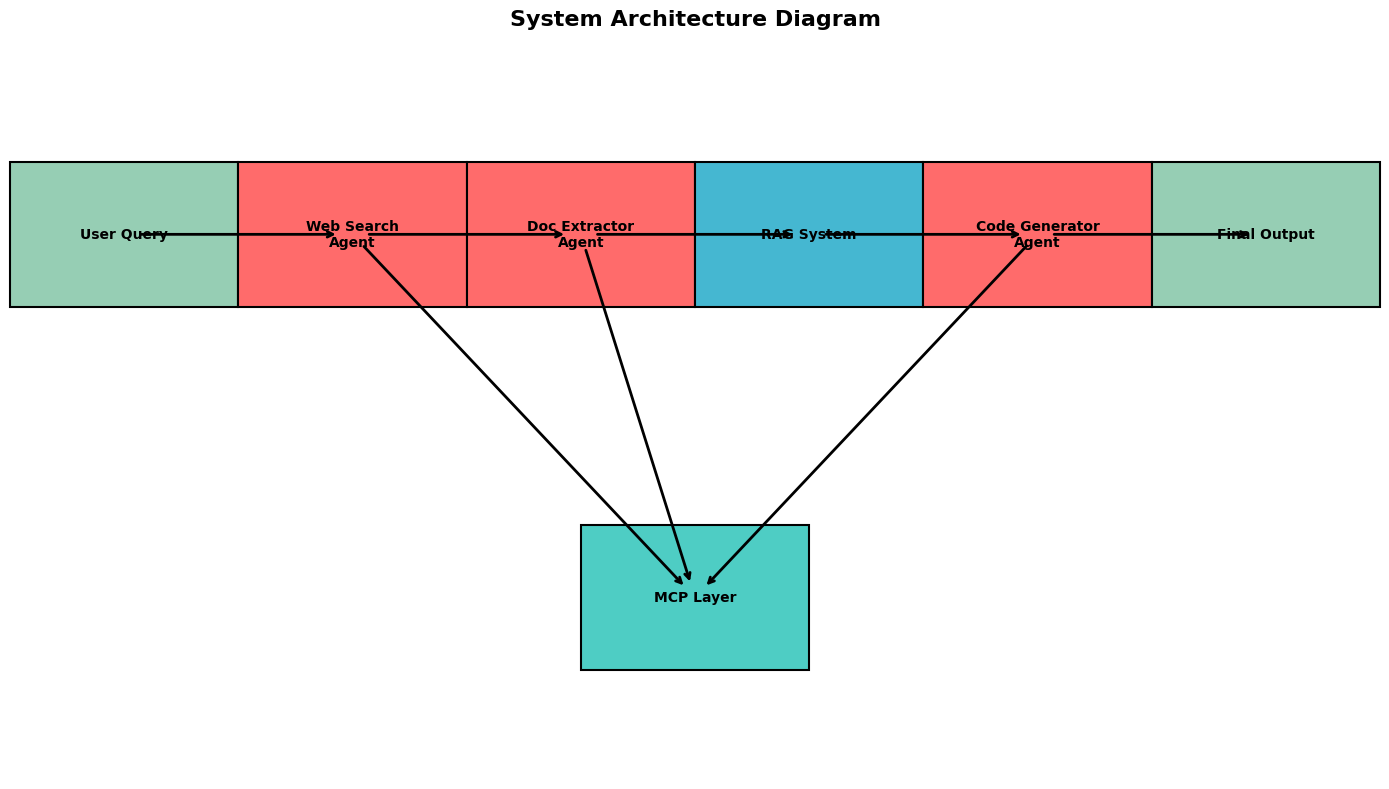

In [ ]:
|import matplotlib.pyplot as plt

# Create a figure and axes for the diagram
fig, ax = plt.subplots(figsize=(14, 8))

# Define the components and their positions
components = {
    'User Query': {'pos': (1, 4), 'color': '#96CEB4'},
    'Web Search\nAgent': {'pos': (3, 4), 'color': '#FF6B6B'},
    'Doc Extractor\nAgent': {'pos': (5, 4), 'color': '#FF6B6B'},
    'RAG System': {'pos': (7, 4), 'color': '#45B7D1'},
    'Code Generator\nAgent': {'pos': (9, 4), 'color': '#FF6B6B'},
    'MCP Layer': {'pos': (6, 2), 'color': '#4ECDC4'}, # Adjusted position for better layout
    'Final Output': {'pos': (11, 4), 'color': '#96CEB4'}
}

# --- Draw Components ---
for comp, props in components.items():
    x, y = props['pos']
    color = props['color']

    # Create a rectangle patch for the component
    rect = plt.Rectangle(
        (x - 1, y - 0.4), 2, 0.8,  # width=2, height=0.8
        facecolor=color,
        edgecolor='black',
        linewidth=1.5,
        clip_on=False # Allow drawing outside of axes boundaries if needed
    )
    ax.add_patch(rect)

    # Add text to the center of the rectangle
    ax.text(x, y, comp, ha='center', va='center', fontsize=10, weight='bold')

# --- Draw Connections ---
# Defines start and end points for arrows
connections = [
    # Main horizontal flow
    ('User Query', 'Web Search\nAgent'),
    ('Web Search\nAgent', 'Doc Extractor\nAgent'),
    ('Doc Extractor\nAgent', 'RAG System'),
    ('RAG System', 'Code Generator\nAgent'),
    ('Code Generator\nAgent', 'Final Output'),
    # Connections to MCP Layer
    ('Web Search\nAgent', 'MCP Layer'),
    ('Doc Extractor\nAgent', 'MCP Layer'),
    ('Code Generator\nAgent', 'MCP Layer')
]

for start_comp, end_comp in connections:
    start_pos = components[start_comp]['pos']
    end_pos = components[end_comp]['pos']

    # Use annotate to draw arrows
    ax.annotate(
        "",
        xy=end_pos,
        xytext=start_pos,
        arrowprops=dict(
            arrowstyle="->",
            lw=2,
            color='black',
            shrinkA=12, # Shorten arrow start to not overlap box
            shrinkB=12  # Shorten arrow end to not overlap box
        )
    )

# --- Final Plot Adjustments ---
# Set plot limits to provide padding
ax.set_xlim(0, 12)
ax.set_ylim(1, 5)

# Hide the axes and border for a cleaner look
ax.axis('off')

# Set a title for the diagram
ax.set_title('System Architecture Diagram', fontsize=16, weight='bold', pad=20)

# Display the plot
plt.tight_layout()
plt.show()